### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 3
### Due: Saturday, Feb 10th at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw3_data_1.npy`. This is a (50 x 2) numpy array, with measurements in the first column and uncertainties in the second column. Using the analytic results for heteroscedastic Gaussian data from lectures, compute the sample mean and the standard error on the sample mean from for this data.

2) Reusing some approaches and tools from `Lecture_6`, write a ln-likelihood function for heteroscedastic Gaussian data, and use it in a fitting algorithm to find the best-fit mean. *Remember that scipy optimizers are set up to minimize functions.*

3) Using the same numerical technique from `Lecture_5`, compute the Fisher uncertainty estimate on the mean.

4) Using the bootstrap method, generate $1000$ bootstrap realizations of this dataset. *DO NOT use the `astroML` code. Write your own bootstrap function from scratch. Also recall that when resampling data, measurements and uncertainties should stay paired together.*

5) Repeat (2) with all $1000$ boostrap datasets to find the distribution of the sample mean. Plot a normalized histogram of these bootstrap means, and overplot a Gaussian pdf with the mean and std found in (1). Do these agree?

6) While we have fitted a heteroscedastic Gaussian to this data, let's try something else. Write some code to define a ln-likelihood for a Laplace distribution evaluated on this data. Fit simultaneously for the Laplace location parameter $\mu$ and scale parameter $\Delta$.

7) Compute the AIC values for the heteroscedastic Gaussian model and the Laplacian model. Which model is favored by the data?

8) Using the $1000$ bootstrap datasets from before, fit for the Laplacian $\mu$ and $\Delta$ for each. Make a nice `corner` plot of the distributions of $\mu$ and $\Delta$ that shows both the marginal $1$D distributions and the joint $2$D distribution. Make sure the plot has labels, shows the titles on each $1$D marginal panel, and has $68\%$ and $95\%$ levels.

9) Let's finish with a Fisher uncertainty estimate of the Laplacian parameters. Use the following code to install `numdifftools` which provides a simple way to compute derivatives. We can then compute the Hessian matrix, which is the matrix of the second derivatives of the user's function. This should be computed at the best-fit Laplacian parameters $\mu$ and $\Delta$. To finish, invert the matrix, and then take the square root. The diagonal entries will then be the Fisher uncertainties on $\mu$ and $\Delta$. How does these compare to the bootstrap distribution widths found in (8)?

In [1]:
!pip install numdifftools

In [55]:
import numdifftools as nd
import numpy as np 
import scipy
import matplotlib.pyplot as plt
from scipy import optimize
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker, VPacker
import chainconsumer
import corner


In [3]:
# For later:
# H = nd.Hessian(f_lnlaplace)([beta_laplace[0], beta_laplace[1]])
# sigma_laplace = np.linalg.inv(H)**0.5

### Solution

# 1

In [4]:
data = np.load('../../../homeworks/hw_data/hw3_data_1.npy')

$$\hat \mu = \frac{\sum_i^N (x_i/\sigma_i^2)}{\sum_i^N (1/\sigma_i^2)},$$

with uncertainty
$$\sigma_{\mu} = \left( \sum_{i=1}^N \frac{1}{\sigma_i^2}\right)^{-1/2}.$$


In [5]:
def het_mean_sigma_analytic(data):
    '''
    A function to analytically calculate the mean and uncert on mean for 
    a heteroscedastic dataset

    inputs:
    data (ndarray): N measurements x 2 array where [:, 1] are the uncertainties

    returns:
    mean (float): mean analytically calculated for heteroscedastic data
    sigmu (float): uncertainty on the mean analytically calc.
    '''
    numerator = np.sum(data[:, 0] / data[:, 1]**2) # LSS sum of measurement over
    # the square of the respective uncertainties
    denom = np.sum(data[:, 1]**-2) # LSS sum of the inverse square of the uncert.

    mean = numerator / denom

    sigmu = denom**-0.5 # LSS uncert on mean is denominator to the -0.5
    return mean, sigmu

In [6]:
datamean_an, datasigmu_an = het_mean_sigma_analytic(data)

In [7]:
print(f'analytically calculated mu={datamean_an:.2f}, sigma_mu={datasigmu_an:.2f}')

analytically calculated mu=3.92, sigma_mu=0.09


# 2

In [8]:
def neglnlik(mu_model, data, uncert, modelname='gaussian', scaleparam=np.nan):
    '''
    A function to return the negative log likelihood for data when modeled by a 
    gaussian with mu=mu_model

    inputs:
    mu_model (float): mean for the gaussian model
    data (ndarray): the data to be fit to 
    uncert (ndarray): the uncert for each data point
    outputs:
    neglnlik (float): negative log likelihood for some mu_model 
    '''
    if modelname=='gaussian':
        # LSS calculating likelihood
        neglnlik = np.sum(np.log(1/(uncert*np.sqrt(2*np.pi))) - ((data - mu_model)**2 / (2*uncert**2)))
    
    elif modelname=='laplace': # LSS encoding laplace model
        if np.isnan(scaleparam):
            print('MUST ASSIGN SCALE PARAMETER IF USING LAPLACE MODEL')
            return
        neglnlik = np.sum(np.log(1/(2*scaleparam))+-(np.abs(data-mu_model)/scaleparam))

    return -neglnlik

In [9]:
neglnlik(3.91, data[:, 0], data[:, 1])

147.26141567060225

In [10]:
neglnlik_heterodata = lambda modelguess: neglnlik(modelguess, data=data[:, 0], 
                                            uncert=data[:, 1])
modelguess0 = 3
mean_MLE = optimize.fmin(neglnlik_heterodata, modelguess0)

Optimization terminated successfully.
         Current function value: 147.257863
         Iterations: 16
         Function evaluations: 32


In [11]:
print(f'negative log like minimization best fit mean={mean_MLE[0]:.5f}')
print(f'analytically derived mean of heteroscedastic gaussian = {datamean_an:.5f}')

negative log like minimization best fit mean=3.91802
analytically derived mean of heteroscedastic gaussian = 3.91799


# 3

$$\sigma_{jk} = \sqrt{[F^{-1}]_{jk}}, $$

where

$$ F_{jk} = - \frac{\partial^2}{\partial\theta_j} \frac{\ln L}{\partial\theta_k} \Biggr\rvert_{\theta=\hat \theta}.$$

The matrix $F$ is known as the **observed Fisher information matrix**. The elements $\sigma^2_{jk}$ are known as the ***covariance matrix***.
*The marginal error bars for each parameter, $\theta_i$ are given by the diagonal elements, $\sigma_{ii}$. These are the "error bars" that are typically quoted with each measurement. Off diagonal elements, $\sigma_{ij}$, arise from any correlation between the parameters in the model.*

In our example of a homoscedastic Gaussian, the uncertainly on the mean is 

$$\sigma_{\mu} = \left( - \frac{\partial^2\ln L(\mu)}{\partial\mu^2}\Biggr\rvert_{\hat \mu}\right)^{-1/2}$$

We find

$$\frac{\partial^2\ln L(\mu)}{\partial\mu^2}\Biggr\rvert_{\hat \mu} = - \sum_{i=1}^N\frac{1}{\sigma^2}$$

<font color='orchid'>**Since the dataset is heteroscedastic, we cannot say the sum is simply $$-\frac{N}{\sigma^2}$$ as true 
for the homoscedastic case. The sum instead becomes:**
$$-\sum_{i=1}^N\frac{1}{\sigma_{i}^2}$$
where $\sigma_i$ is the uncertainty on each data point. Finally utilizing the 
power of -1/2, we have:
$$\sigma_{\mu} = [\sum_{i=1}^N\frac{1}{\sigma_{i}^2}]^{-1/2}$$

In [12]:
fisher_sigmu = (np.sum(1/(data[:,1]**2)))**(-1/2)

In [13]:
print(f'Fisher Matrix calculated sigma_mu={fisher_sigmu:.9f}')
print(f'Analytically solved sigma_mu = {datasigmu_an:.9f}')

Fisher Matrix calculated sigma_mu=0.094810841
Analytically solved sigma_mu = 0.094810841


In [91]:
# Read, think about, and execute the following cell
xgrid = np.linspace(0, 8, 1000)
L = np.zeros(1000)
for i in range(1000):
    L[i] = neglnlik(xgrid[i], data[:, 0], uncert=data[:, 1])


sigma_mu = np.diff(np.log(L), n=2)
sigma_mu /= (xgrid[1]-xgrid[0])**2
sigma_mu *= -1
sigma_mu = 1/np.sqrt(sigma_mu)[0]

print("Fisher matrix error on estimated mean is %.3f" % sigma_mu)

Fisher matrix error on estimated mean is 3.567


/var/folders/1y/5f87nyls7mnbqvgd2zgz0lmc0000gr/T/ipykernel_98384/2210338467.py:11: RuntimeWarning: invalid value encountered in sqrt
  sigma_mu = 1/np.sqrt(sigma_mu)[0]


# 4

In [15]:
def bootstrapdata(data, uncert, n=1000):
    ''' 
    A function to create n bootstrapped versions of an input dataset.
    NOTE: data and uncert must be of the same length.

    inputs:
    data (ndarray): data points - should be 1D array
    uncert (ndarray): uncert on the datapoints. 
    n (int): number of datasets to generate. default is 100

    returns
    bootstrap_datasets (ndarray): shape is (n, data.shape[0], 2) for 
    data realization x data points x data and uncert
    '''
    # LSS error handling
    if data.shape[0] != uncert.shape[0]:
        print('DATA and UNCERT must have the same length!')
        return
    
    # LSS getting length of data for bootstrapping
    datalen = data.shape[0]
    bootstrap_datasets = np.zeros(shape=(n, datalen, 2))

    # LSS iterating over number of datasets requested
    for iter in range(n):
        # LSS getting random indices to sample points out of the dataset
        sample_idx = np.random.randint(low=0, high=datalen, size=datalen)
        
        # LSS assigning datasets to be random draws from the data and uncert.
        bootstrap_datasets[iter, :, 0] = data[sample_idx]
        bootstrap_datasets[iter, :, 1] = uncert[sample_idx]
    
    return bootstrap_datasets




# 5

In [16]:
bts_data = bootstrapdata(data=data[:,0], uncert=data[:, 1], n=10000)

In [17]:
# aside: how would i make this to just take in functions in general as well as
# an arbitrary number of guesses

# def bts_optimizer(bootstraps, fn):
#     ''' 
#     a function to optimize model parameters across various bootstrapped datasets
#     fn is the function that is calculating the chisq or the -ln Likelihood. 
#     Regardless, it must be something that returns LOWER values for models that 
#     better fit the data

#     inputs:
#     bootstraps (ndarray): #realizations x datalength x (data, uncert)
#     fn (function): function must take in data=data[:, 0] and uncert=data[:, 1]
#     '''
#     for iter in range(bootstraps.shape[0])
#     neglnlik_heterodata = lambda modelguess: chisq(modelguess[0], modelguess[1], 
#                                                   data=data[:, 0], uncert=data[:, 1])
#     modelguess0 = [2, 1]
#     bestfitmodel = optimize.fmin(neglnlik_heterodata, modelguess0)
    

In [31]:
def bts_optimizer(bootstraps, fn_name='hetgauss'):
    ''' 
    a function to optimize model parameters across various bootstrapped datasets
    fn_name is the name of the model you are using to fit the data.
    Options are:
    'hetgauss' for heteroscedastic gaussian 
    'Laplacian' IN DEV

    inputs:
    bootstraps (ndarray): #realizations x datalength x (data, uncert)
    fn_name (str): default is 'hetgauss'
    '''
    # LSS handling hetgauss modeling
    if fn_name=='hetgauss':
        realzns = bootstraps.shape[0]
        bootstrap_mu = np.zeros(shape=(realzns))
        # LSS iterate over realizations
        for iter in range(realzns):
            # LSS create lambda function that calls the right dataset
            neglnlik_heterodata = lambda modelguess: neglnlik(modelguess, 
                                                              data=bootstraps[iter, :, 0], 
                                                              uncert=bootstraps[iter, :, 1])
            modelguess0 = 3
            # LSS optimize
            mean_MLE = optimize.fmin(neglnlik_heterodata, modelguess0);
        
            # LSS save min chisq values
            bootstrap_mu[iter] = mean_MLE[0]

        bootstrap_params = bootstrap_mu

    # LSS handling laplacian model
    if fn_name=='laplace':
        realzns = bootstraps.shape[0]
        bootstrap_mu_delta = np.zeros(shape=(realzns, 2))
        # LSS iterate over the realizations
        for iter in range(realzns):
            neglnlik_laplace = lambda modelguess: neglnlik(mu_model=modelguess[0], 
                                               scaleparam=modelguess[1], 
                                               data=bootstraps[iter, :, 0], uncert=bootstraps[iter, :, 1],
                                               modelname='laplace')
            modelguess0 = [4, 1]
            bootstrap_mu_delta[iter, :] = optimize.fmin(neglnlik_laplace, modelguess0)

        bootstrap_params = bootstrap_mu_delta
    
    return bootstrap_params    

In [36]:
# getting bootstrapped means and sigmas
bootstrap_mu = bts_optimizer(bts_data, fn_name='hetgauss')

Optimization terminated successfully.
         Current function value: 157.172442
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 139.163353
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 151.417653
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 144.727309
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 147.149519
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 150.354448
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 151.187056
         Iterations: 16
         Function evaluations: 32
Optimization termina

In [37]:
# LSS fancy plotting from https://stackoverflow.com/questions/33159134/matplotlib-y-axis-label-with-multiple-colors

def multicolor_ylabel(ax,list_of_strings,list_of_colors,axis='x',anchorpad=0,**kw):
    """this function creates axes labels with multiple colors
    ax specifies the axes object where the labels should be drawn
    list_of_strings is a list of all of the text items
    list_if_colors is a corresponding list of colors for the strings
    axis='x', 'y', or 'both' and specifies which label(s) should be drawn"""
    from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker, VPacker

    # x-axis label
    if axis=='x' or axis=='both':
        boxes = [TextArea(text, textprops=dict(color=color, ha='left',va='bottom',**kw)) 
                    for text,color in zip(list_of_strings,list_of_colors) ]
        xbox = HPacker(children=boxes,align="center",pad=0, sep=5)
        anchored_xbox = AnchoredOffsetbox(loc=3, child=xbox, pad=anchorpad,frameon=False,bbox_to_anchor=(0.2, -0.09),
                                          bbox_transform=ax.transAxes, borderpad=0.)
        ax.add_artist(anchored_xbox)

    # y-axis label
    if axis=='y' or axis=='both':
        boxes = [TextArea(text, textprops=dict(color=color, ha='left',va='bottom',rotation=90,**kw)) 
                     for text,color in zip(list_of_strings[::-1],list_of_colors) ]
        ybox = VPacker(children=boxes,align="center", pad=0, sep=5)
        anchored_ybox = AnchoredOffsetbox(loc=3, child=ybox, pad=anchorpad, frameon=False, bbox_to_anchor=(-0.10, 0.2), 
                                          bbox_transform=ax.transAxes, borderpad=0.)
        ax.add_artist(anchored_ybox)

In [38]:
print(datamean_an, datasigmu_an)

3.917992034606055 0.09481084100510954


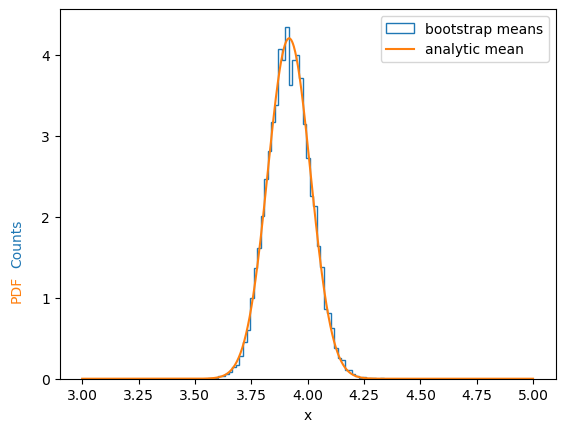

In [39]:
# LSS nice comparison plot
xgrid = np.linspace(3, 5, 1000)
#normalizepdf = np.sum(scipy.stats.norm(datamean_an, datasigmu_an).pdf(xgrid))
ax = plt.subplot(111)
ax.hist(bootstrap_mu, density=True, histtype='step', label='bootstrap means', bins=50)
ax.plot(xgrid, scipy.stats.norm(loc=datamean_an, scale=datasigmu_an).pdf(xgrid), label='analytic mean')
ax.legend()
ax.set_xlabel('x')
multicolor_ylabel(ax, ('PDF', 'Counts'), ('C0', 'C1'), axis='y')


#plt.ylabel('PDF', color='C1')


# 6

In [24]:
neglnlik(mu_model=10, scaleparam=2, data=data[:, 0], uncert=data[:, 1], 
         modelname='laplace')

441.7520605065389

In [25]:
neglnlik_laplace = lambda modelguess: neglnlik(mu_model=modelguess[0], 
                                               scaleparam=modelguess[1], 
                                               data=data[:, 0], uncert=data[:, 1],
                                               modelname='laplace')
modelguess0 = [4, 1]
mean_MLE_laplace = optimize.fmin(neglnlik_laplace, modelguess0)

Optimization terminated successfully.
         Current function value: 156.788916
         Iterations: 46
         Function evaluations: 84


In [26]:
mean_MLE_laplace

array([4.08828816, 0.88226923])

# 7

In [27]:
def calcAIC(maxlnlik, numparams, numdatapts):
    ''' 
    A function to calculate the Akaike Information Criterion to evaluate models
    against each other. The lower the AIC is, the better the model fits + simpler
    it is.
    
    inputs:
    maxlnlik (float): max lnlikelihood from optimal model params
    numparams (int): number of params in the model
    numdatapts (int): number of data points in the dataset the model is fitting.

    outputs:
    aic (float): the aic for given lnlik and numparams
    '''
    aic = (-2*maxlnlik + 2*numparams + 
           (2*numparams*(numparams+1)) / (numdatapts - numparams - 1))
    return aic

In [28]:
data.shape[0]

100

In [29]:
# LSS heterosc max likelihood:
gauss_maxlik = neglnlik(mu_model=mean_MLE[0], data=data[:, 0], uncert=data[:, 1])
laplace_maxlik = neglnlik(mu_model=mean_MLE_laplace[0], 
                            scaleparam=mean_MLE_laplace[1], data=data[:, 0], 
                            uncert=data[:, 1], modelname='laplace')

aic_hetgauss = calcAIC(-gauss_maxlik, mean_MLE.shape[0], data.shape[0])
aic_laplace = calcAIC(-laplace_maxlik, mean_MLE_laplace.shape[0], data.shape[0])
print(f'AIC for gaussian = {aic_hetgauss}')
print(f'AIC for laplacian= {aic_laplace}')


AIC for gaussian = 296.5565421737329
AIC for laplacian= 317.7015436933863


# 8

In [40]:
bootstrap_mu_delta = bts_optimizer(bts_data, fn_name='laplace')

Optimization terminated successfully.
         Current function value: 170.193814
         Iterations: 37
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: 149.334369
         Iterations: 38
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: 162.178784
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: 153.164723
         Iterations: 46
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: 154.414400
         Iterations: 48
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: 156.783476
         Iterations: 42
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: 161.236129
         Iterations: 41
         Function evaluations: 75
Optimization termina

Dotted Lines are the 50%, 68%, 95% quantiles (going from middle outward)


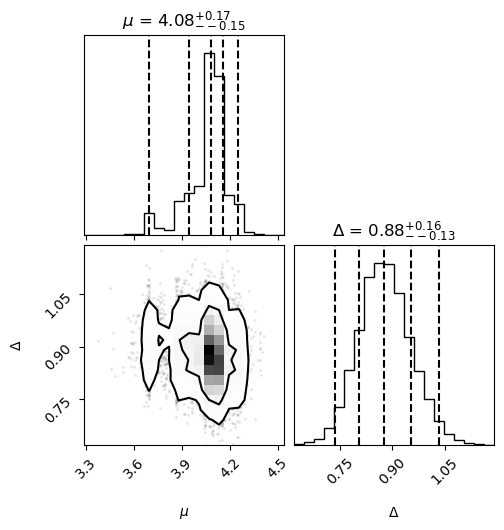

In [85]:
corner.corner(bootstrap_mu_delta, labels=[r'$\mu$', r'$\Delta$'], show_titles=True, 
              levels=(0.68, 0.95), quantiles=[0.025, 0.16, 0.5, 0.84, 0.975],
              title_quantiles=[.95, .5, .975]);

print('Dotted Lines are the 50%, 68%, 95% quantiles (going from middle outward)')

# 9

In [76]:
import numdifftools as nd

In [78]:
H = nd.Hessian(neglnlik_laplace)([mean_MLE_laplace[0], mean_MLE_laplace[1]])
sigma_laplace = np.linalg.inv(H)**0.5

In [82]:
print(rf'Hessian Uncertainty in $\mu$ = {sigma_laplace[0, 0]}')
print(rf'Hessian Uncertainty in $\Delta$ = {sigma_laplace[1, 1]}')

Hessian Uncertainty in $\mu$ = 0.10923079801233879
Hessian Uncertainty in $\Delta$ = 0.08822813761196263


* The uncertainty in $\mu$ is close-ish, but uncertainty in $\Delta$ is almost
halved. Not sure if I messed something up but they are close?